In [ ]:
import glob
from collections import defaultdict
from multiprocessing import Pool

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

import warnings
warnings.filterwarnings("ignore")

## Analyse 

In [ ]:
obs_df_ns_flt = pd.read_csv('dataset/obs_muts.csv')
obs_df_ns_flt

,Mut,MutType,Site,PosInCodon,RefCodon,AltCodon,RefAa,AltAa,ProbaRef,ProbaMut,RefNode,AltNode,species,gene,class,edge_nobs,species_nobs
0,A[A>G]T,0,112,1,ATT,GTT,I,V,0.958489,0.849141,Node5,Node6,Macaca_mulatta,ND6,Mammalia,1.70197,60.8728
1,T[G>A]T,0,127,1,GTT,ATT,V,I,0.974793,0.970650,Node6,Node12,Macaca_mulatta,ND6,Mammalia,4.31735,60.8728
2,G[A>G]T,0,301,1,ATA,GTA,M,V,0.999990,0.999990,Node24,RN_6,Macaca_mulatta,ND6,Mammalia,0.99999,60.8728
3,T[G>A]T,0,109,1,GTA,ATA,V,M,0.999990,0.999990,Node22,RN_32,Macaca_mulatta,ND6,Mammalia,0.99999,60.8728
4,A[A>G]T,0,97,1,ATT,GTT,I,V,1.000000,1.000000,Node25,RN_5,Macaca_mulatta,ND6,Mammalia,1.00000,60.8728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71036,G[T>C]T,0,320,2,GTT,GCT,V,A,0.997300,0.996791,Node7,Node15,Microtus_richardsoni,CO3,Mammalia,2.99087,37.8538
71037,A[G>A]C,0,470,2,AGC,AAC,S,N,0.976132,0.976132,Node8,Node14,Microtus_richardsoni,CO3,Mammalia,5.21561,37.8538
71038,A[C>T]T,0,139,1,CTT,TTT,L,F,0.980432,0.980432,Node9,RN_10,Microtus_richardsoni,CO3,Mammalia,5.85689,37.8538
71039,A[A>G]T,0,574,1,ATC,GTC,I,V,0.960485,0.960485,Node9,RN_10,Microtus_richardsoni,CO3,Mammalia,5.85689,37.8538


In [ ]:
amino_acid_codes = {
    "A": "Ala",
    "R": "Arg",
    "N": "Asn",
    "D": "Asp",
    "C": "Cys",
    "Q": "Gln",
    "E": "Glu",
    "G": "Gly",
    "H": "His",
    "I": "Ile",
    "L": "Leu",
    "K": "Lys",
    "M": "Met",
    "F": "Phe",
    "P": "Pro",
    "S": "Ser",
    "T": "Thr",
    "W": "Trp",
    "Y": "Tyr",
    "V": "Val",
    "*": "*",
}
obs_df_ns_flt['RefAa'] = obs_df_ns_flt['RefAa'].map(amino_acid_codes)
obs_df_ns_flt['AltAa'] = obs_df_ns_flt['AltAa'].map(amino_acid_codes)

In [ ]:
- split to genes and maybe classes

In [ ]:
exp_aa_subst = pd.read_csv('../1main_aa_subst_trends/data/exp_aa_subst_vert.csv')
exp_aa_subst = exp_aa_subst[exp_aa_subst.aa1 != exp_aa_subst.aa2]
exp_aa_subst

,aa1,aa2,rate
1,Ala,Asp,0.051108
2,Ala,Glu,0.051108
3,Ala,Gly,0.028130
4,Ala,Pro,0.116582
5,Ala,Ser,0.073379
...,...,...,...
154,Val,Gly,0.033067
155,Val,Ile,0.956453
156,Val,Leu,0.153271
157,Val,Met,0.956453


In [ ]:
aa_subst = obs_df_ns_flt[obs_df_ns_flt.gene != 'ND6'].groupby(['RefAa', 'AltAa']).ProbaMut.sum().reset_index()
aa_subst = aa_subst[aa_subst.RefAa != aa_subst.AltAa]
aa_subst.columns = ['aa1', 'aa2', 'nobs']
aa_subst = aa_subst.merge(exp_aa_subst)
aa_subst

,aa1,aa2,nobs,rate
0,Ala,Asp,91.588633,0.051108
1,Ala,Glu,72.545103,0.051108
2,Ala,Gly,454.441360,0.028130
3,Ala,Pro,241.657841,0.116582
4,Ala,Ser,342.995517,0.073379
...,...,...,...,...
135,Val,Gly,299.862048,0.033067
136,Val,Ile,4690.709572,0.956453
137,Val,Leu,435.323427,0.153271
138,Val,Met,1640.286615,0.956453


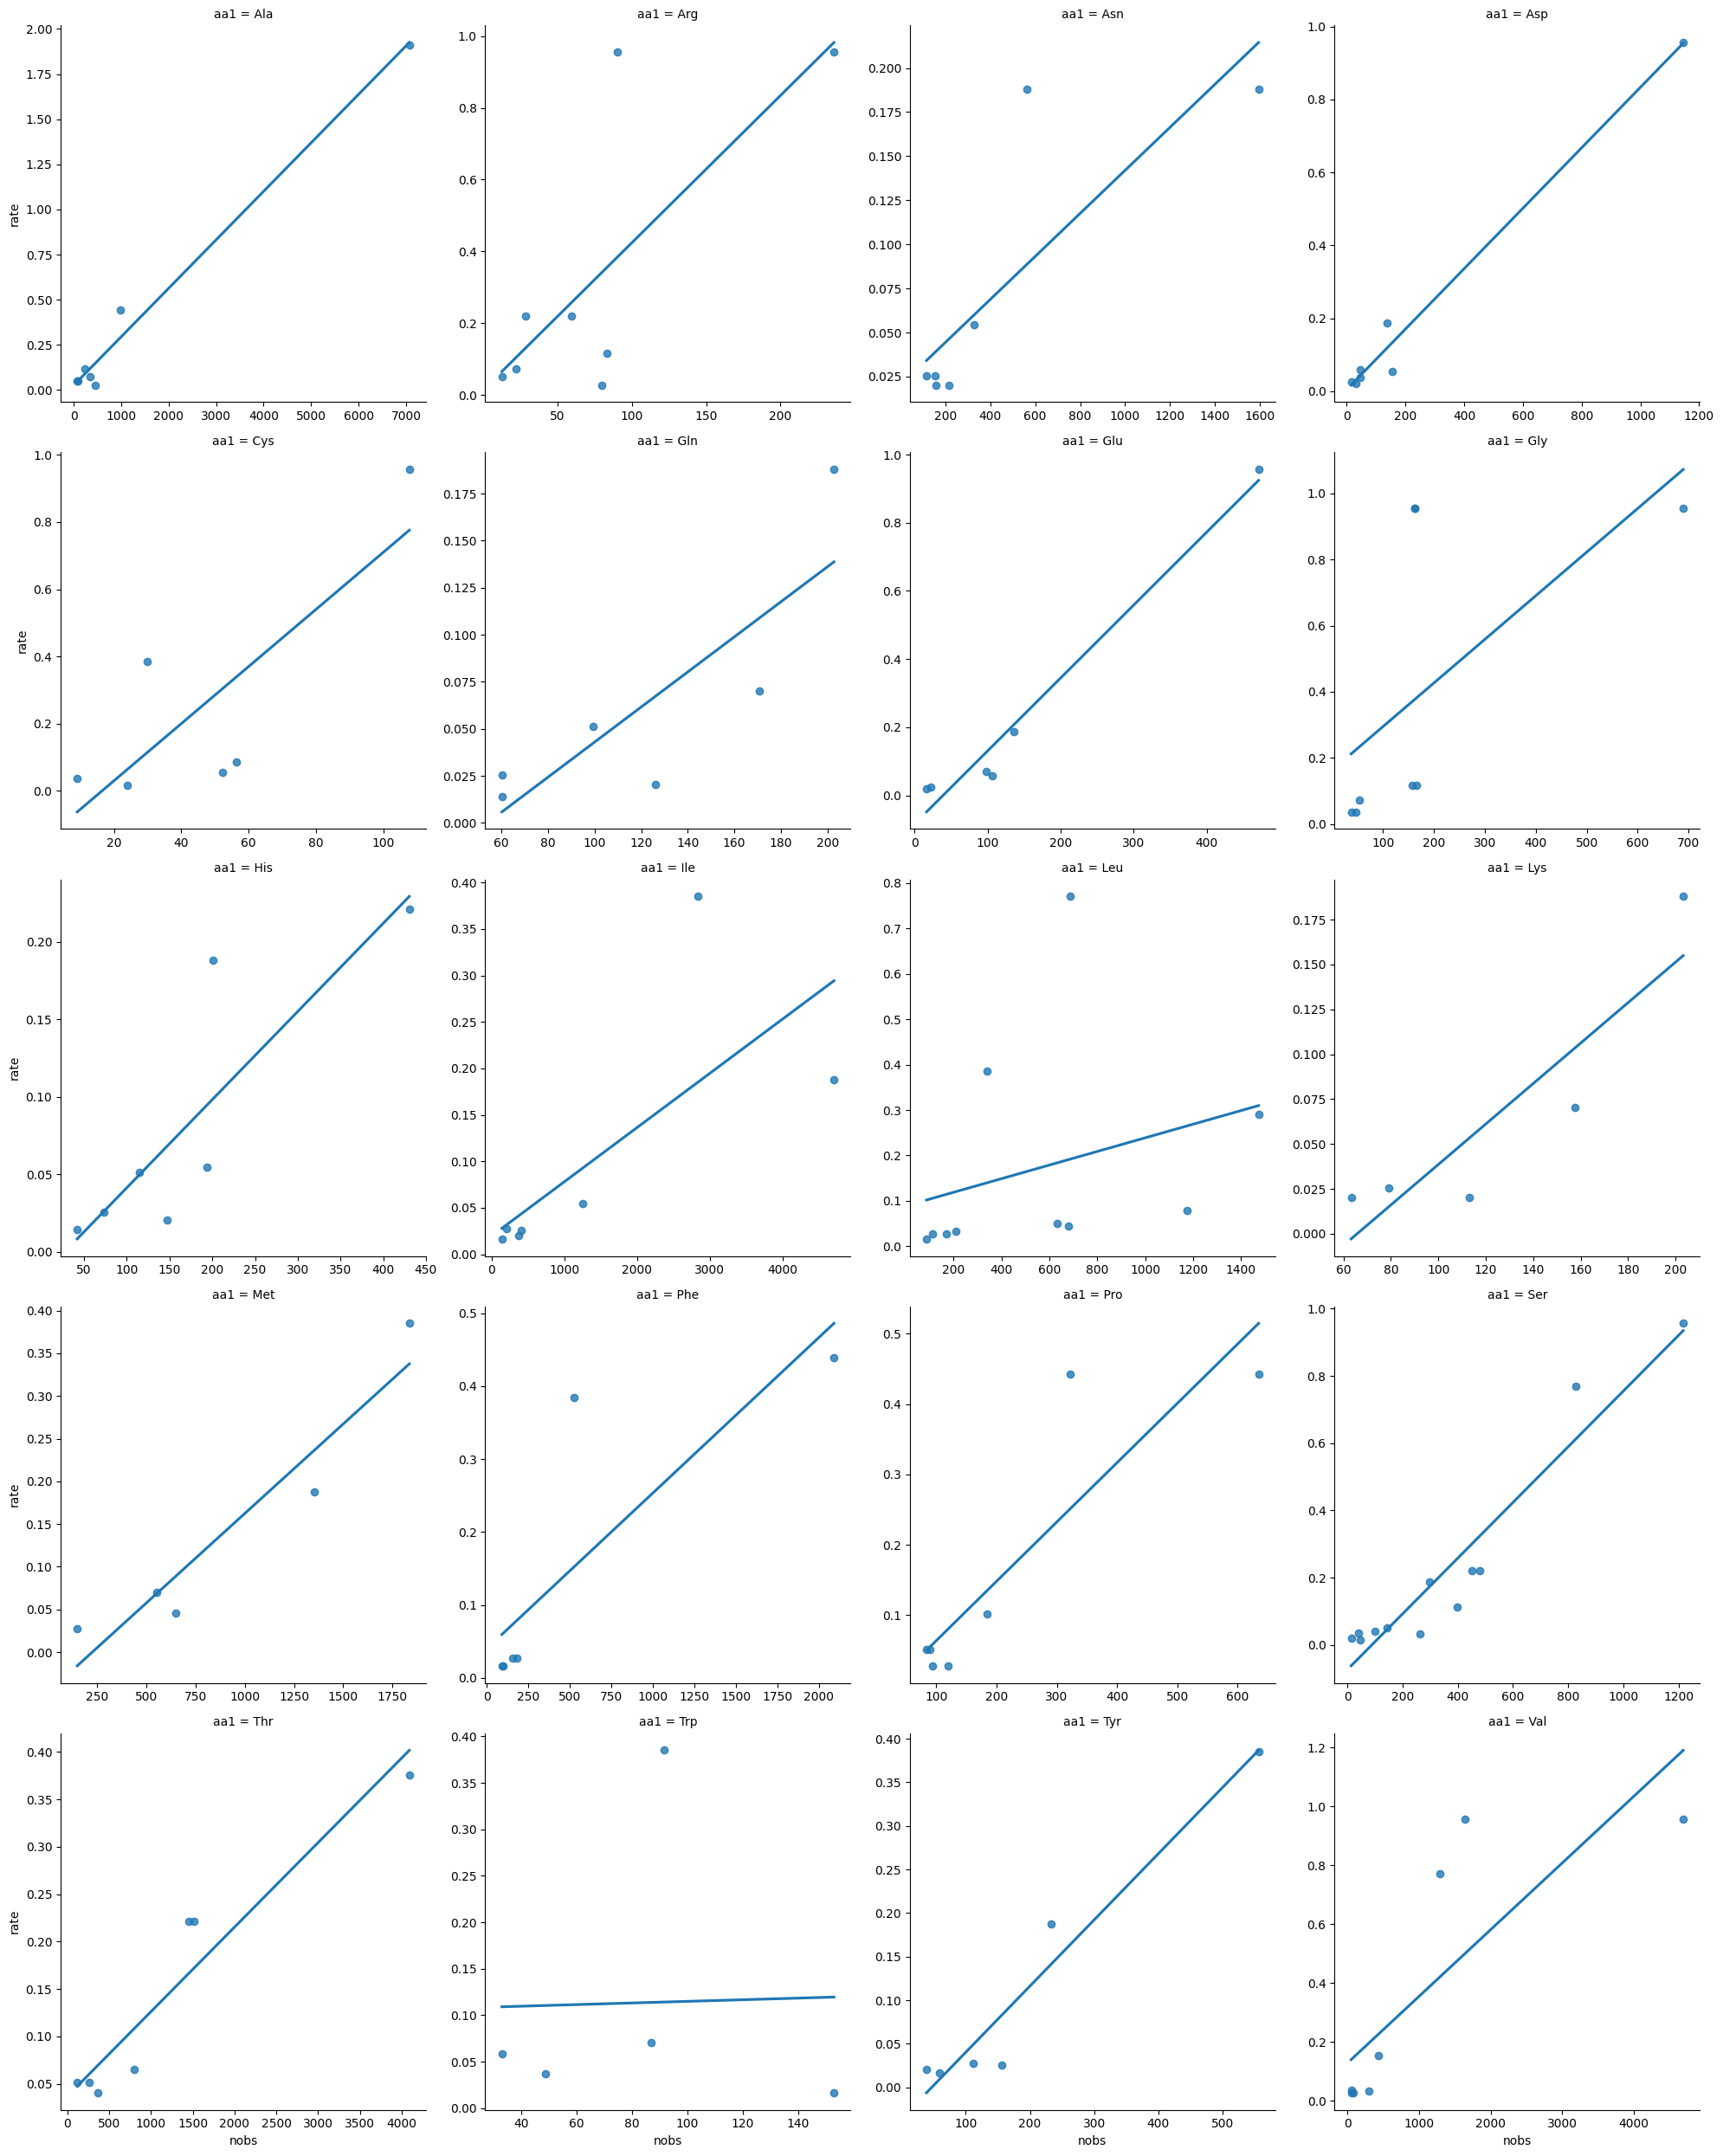

In [ ]:
sns.lmplot(aa_subst, x='nobs', y='rate', col='aa1',
           col_wrap=4, sharex=False, sharey=False, ci=None)

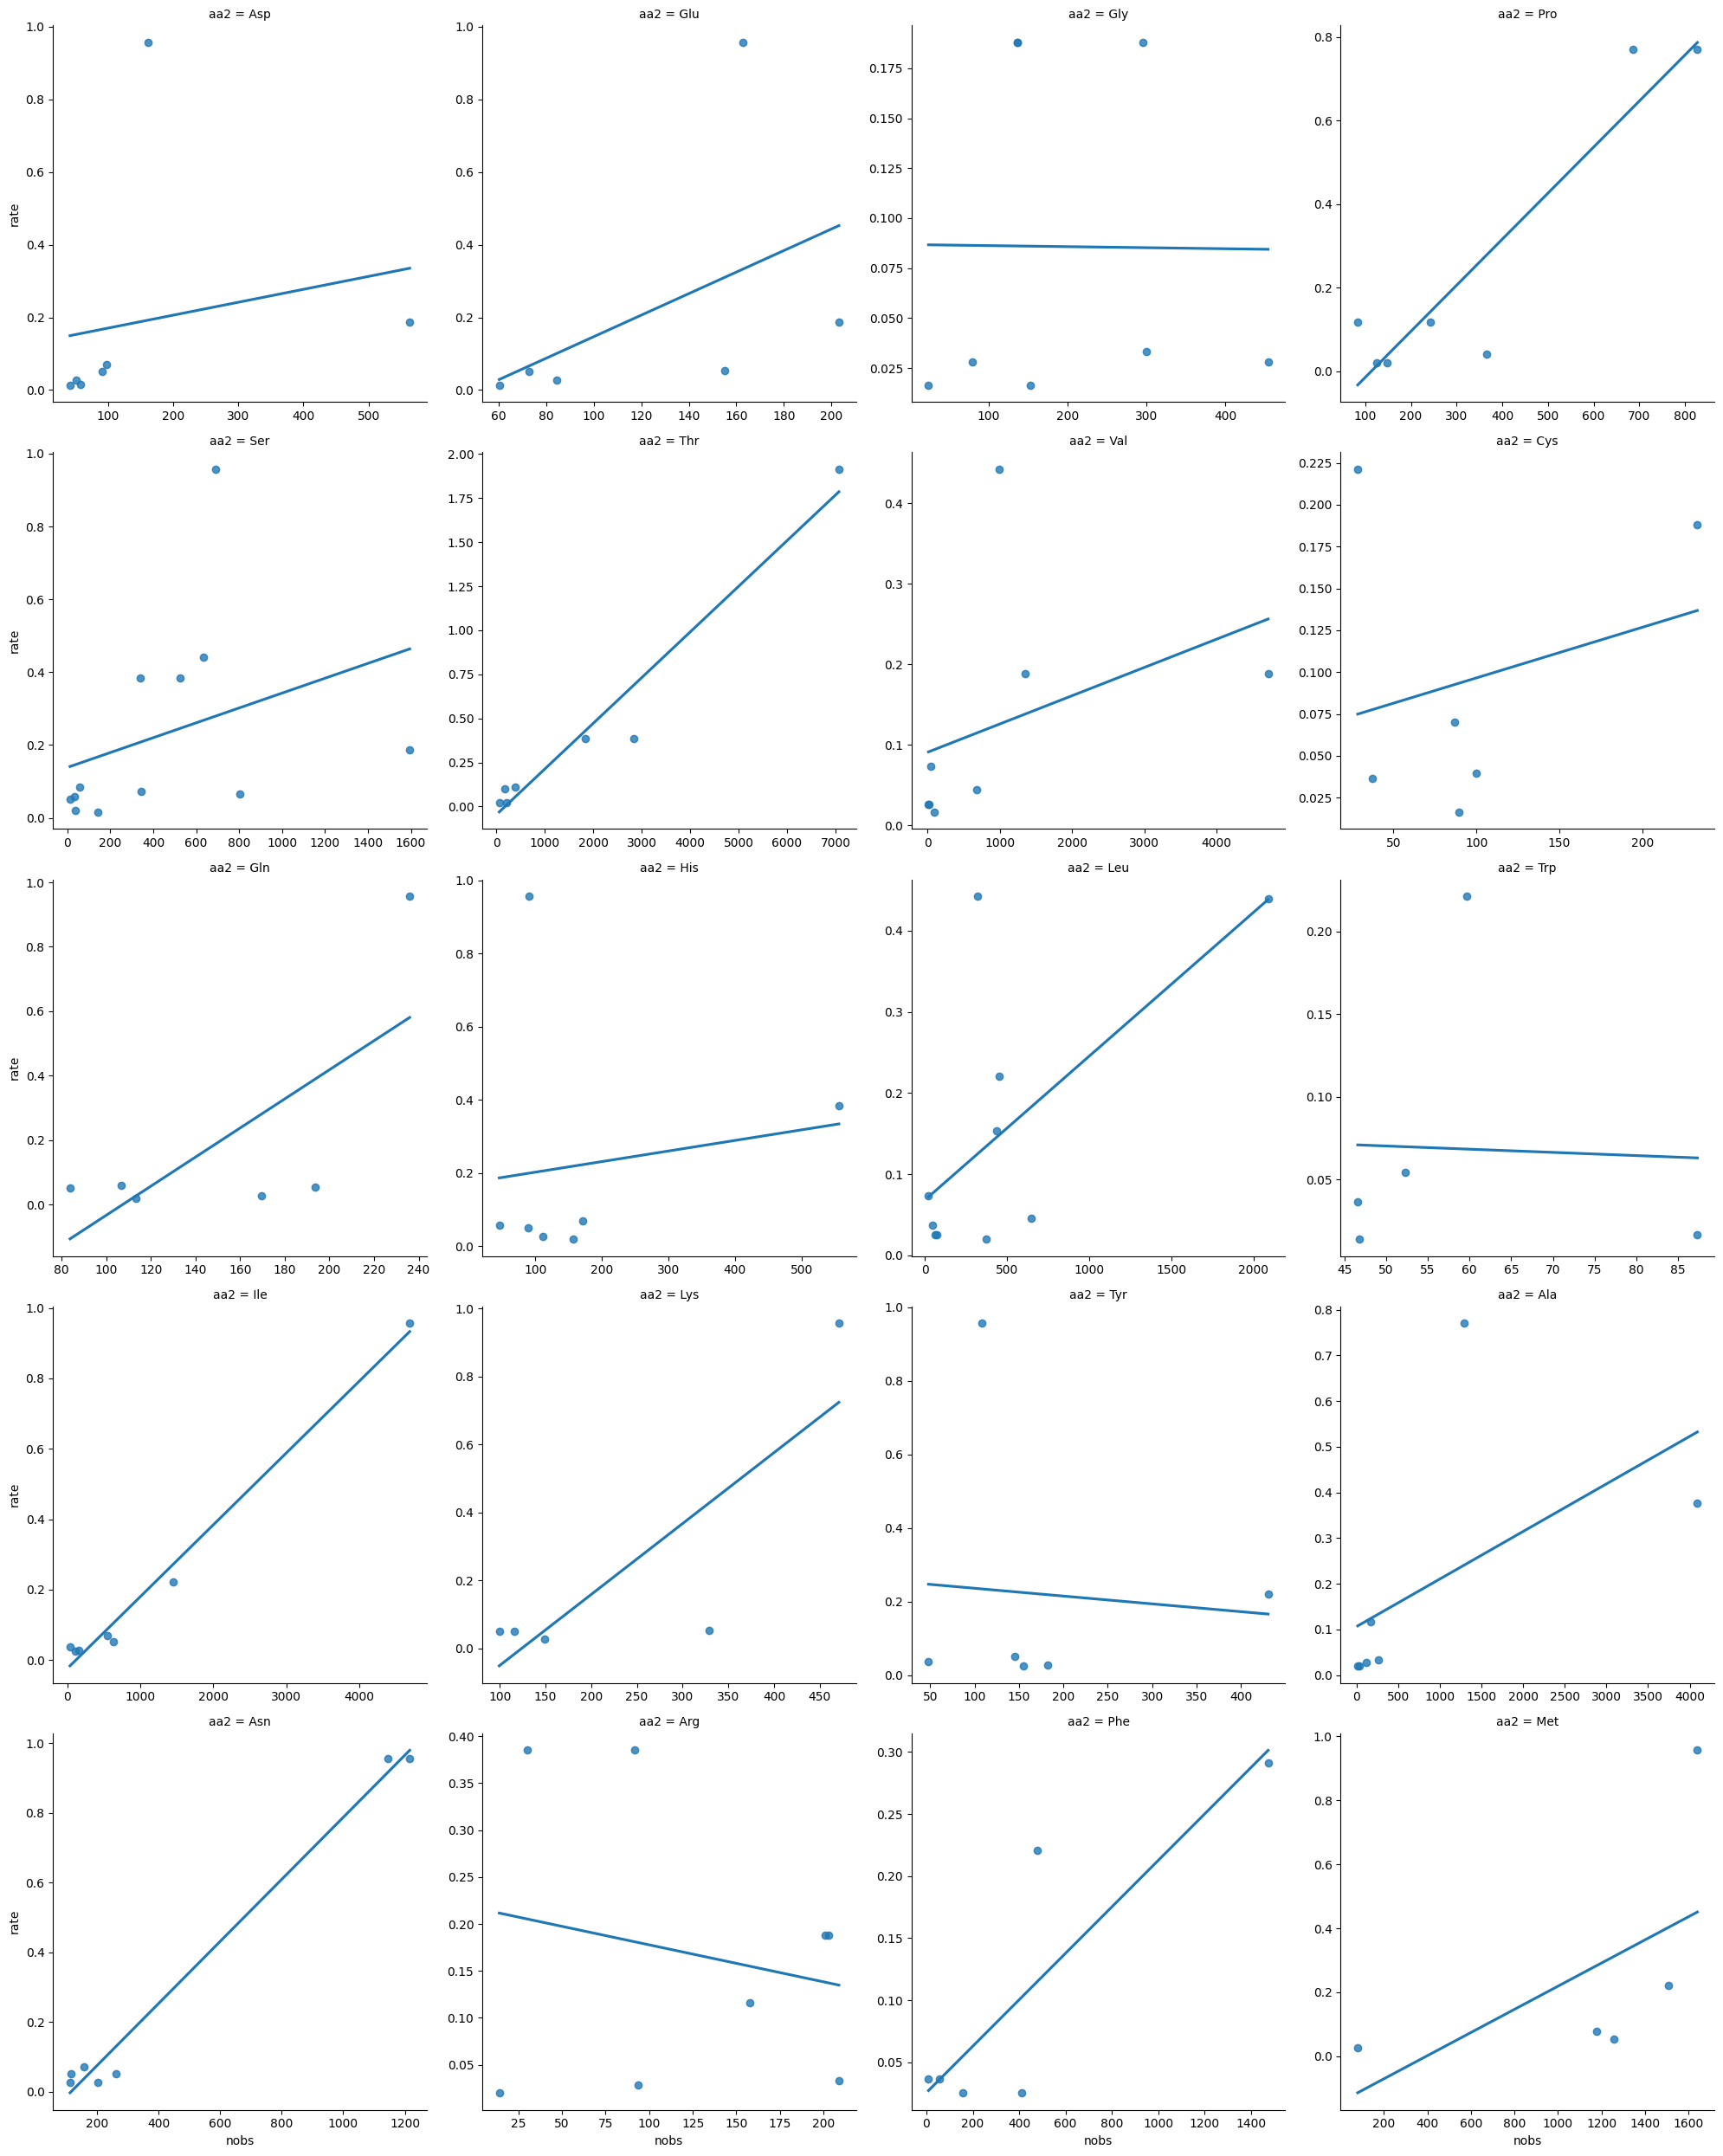

In [ ]:
sns.lmplot(aa_subst, x='nobs', y='rate', col='aa2',
           col_wrap=4, sharex=False, sharey=False, ci=None)

In [ ]:
import numpy as np
from scipy.stats import chisquare, ks_2samp, pearsonr, spearmanr
from scipy.special import kl_div
from sklearn.metrics import mean_squared_error

# Пример данных
# observed = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
# expected = np.array([0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05])

observed = aa_subst.nobs.values
expected = aa_subst.rate.values

observed /= observed.sum()
expected /= expected.sum()

# 1. Критерий согласия Пирсона (χ²)
chi2_stat, chi2_p = chisquare(observed, expected)
print(f"χ² статистика: {chi2_stat:.2f}, p-value: {chi2_p:.3f}")

# 2. Критерий Колмогорова-Смирнова
ks_stat, ks_p = ks_2samp(observed, expected)
print(f"KS статистика: {ks_stat:.2f}, p-value: {ks_p:.3f}")

# 3. Логарифмическое правдоподобие (Log-Likelihood)
log_likelihood = np.sum(observed * np.log(expected) + (1 - observed) * np.log(1 - expected))
print(f"Логарифмическое правдоподобие: {log_likelihood:.2f}")

# 4. Среднеквадратичная ошибка (MSE)
mse = mean_squared_error(observed, expected)
print(f"MSE: {mse:.5f}")

# 5. Корреляция Пирсона и Спирмена
pearson_corr, pearson_p = pearsonr(observed, expected)
spearman_corr, spearman_p = spearmanr(observed, expected)
print(f"Корреляция Пирсона: {pearson_corr:.2f}, p-value: {pearson_p:.3f}")
print(f"Корреляция Спирмена: {spearman_corr:.2f}, p-value: {spearman_p:.3f}")

# 6. KL-дивергенция
kl_divergence = np.sum(kl_div(observed, expected))
print(f"KL-дивергенция: {kl_divergence:.2f}")

# 7. Бутстреп-тест (пример)
def bootstrap_test(observed, expected, n_iterations=1000):
    differences = observed - expected
    bootstrap_samples = np.random.choice(differences, size=(n_iterations, len(differences)), replace=True)
    bootstrap_means = np.mean(bootstrap_samples, axis=1)
    observed_mean_diff = np.mean(differences)
    p_value = np.mean(bootstrap_means >= observed_mean_diff)
    return p_value

bootstrap_p = bootstrap_test(observed, expected)
print(f"Бутстреп p-value: {bootstrap_p:.2f}")

χ² статистика: 1.91, p-value: 1.000
KS статистика: 0.09, p-value: 0.584
Логарифмическое правдоподобие: -5.61
MSE: 0.00015
Корреляция Пирсона: 0.55, p-value: 0.000
Корреляция Спирмена: 0.56, p-value: 0.000
KL-дивергенция: 0.63
Бутстреп p-value: 0.50


In [1]:
для каждой отдельной мутации можно оценить правдоподобие того, что она движется согласно нашим ожиданиям

т.е. у нас есть вероятность наблюденной мутации

нет, надо посчитать ожидаемые каунты вместо вероятностей и сравнивать с наблюдаемыми:

- пересекать множества мутаций
- счиатать абсолютные различия, что есть суть 1 пункта выше

SyntaxError: invalid syntax (3235886167.py, line 1)